In [ ]:
import yfinance as yf #biblioteka yfinance - umożliwia łatwe pobranie pliku csv z potrzebnymi danymi z yahoo finance

symbol = "NVDA" #określenie firmy/znacznika

data = yf.download(symbol, start="1999-01-23", end="2024-01-29", auto_adjust=False) #określenie zakresu

data.to_csv(f"{symbol}.csv") #zapis do pliku csv
#plik csv należy przenieść do folderu data lub poprawić ścieżkę w kodzie dataset = pd.read_csv("data/NVDA.csv")

print(f"saved as: {symbol}.csv")

In [ ]:
#import libraries
import numpy as np #biblioteka do operacji numerycznych
import pandas as pd #biblioteka do analizy danych i  operacji na tabelach
import matplotlib.pyplot as plt #biblioteka do tworzenia wykresów
from sklearn import metrics #biblioteka zawierająca miary oceny modeli
from sklearn.preprocessing import MinMaxScaler #biblioteka do normalizacji danych
from keras.models import Sequential #model warstowy uczenia maszynowego
from keras.layers import Dense #warstwa w której każda jednostka jest połączona z każdą jednostką
from keras.layers import LSTM #warstwa zapamiętująca długoterminowe zależności w danych
from keras.layers import Dropout #funkcja odpowiadająca za usuwanie częsci neuronów aby zapobiec przeuczeniu

In [ ]:
#import pliku CSV
dataset = pd.read_csv("data/NVDA.csv")

In [ ]:
dataset.describe() #wyświetlenie statystyk opisowych

,High,Low,Open,Close,Volume,Adj Close
count,6293.000000,6293.000000,6293.000000,6293.000000,6.293000e+03,6293.000000
mean,4.445956,4.285278,4.366713,4.369681,6.088324e+08,4.342227
std,9.420786,9.093614,9.260408,9.267105,4.347566e+08,9.266446
min,0.035547,0.033333,0.034896,0.034115,1.968000e+07,0.031286
25%,0.282000,0.266000,0.272750,0.272583,3.463120e+08,0.249982
50%,0.455000,0.440000,0.448000,0.447750,5.105480e+08,0.414752
75%,3.912500,3.782500,3.846250,3.843250,7.396320e+08,3.805442
max,62.848999,60.849998,62.349998,61.617001,9.230856e+09,61.599533


In [ ]:
dataset.info() #opis strukruty np. ilość kolumn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6293 entries, 0 to 6292
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6293 non-null   object 
 1   High       6293 non-null   float64
 2   Low        6293 non-null   float64
 3   Open       6293 non-null   float64
 4   Close      6293 non-null   float64
 5   Volume     6293 non-null   int64  
 6   Adj Close  6293 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 344.3+ KB


In [ ]:
dataset.head() #wyświetlenie pierwszych pięciu wierszy

,Date,High,Low,Open,Close,Volume,Adj Close
0,1999-01-25,0.045833,0.041016,0.044271,0.045313,510480000,0.041556
1,1999-01-26,0.046745,0.041146,0.045833,0.041797,343200000,0.038331
2,1999-01-27,0.042969,0.039583,0.041927,0.041667,244368000,0.038212
3,1999-01-28,0.041927,0.041276,0.041667,0.041536,227520000,0.038092
4,1999-01-29,0.041667,0.039583,0.041536,0.039583,244032000,0.036301


In [ ]:
#scale values to range 0-1
trainset = dataset.iloc[:, 3:4].values #wybór kolumnę close a wynikiem bedzie tablica (biblioteka NumPy)
scaler = MinMaxScaler(feature_range = (0,1)) #ustawienie zakresu normalizacji
data_scaled = scaler.fit_transform(trainset) #obliczenie minimalnej i maksymalnej wartosci z kolumny close oraz normalizacja
data_scaled #wynik

array([[1.50445047e-04],
       [1.75511191e-04],
       [1.12829750e-04],
       ...,
       [9.67166906e-01],
       [1.00000000e+00],
       [9.77694021e-01]])

In [ ]:
#split dataset to train and test sets
x_train = []
y_train = []
window = 70 #okrślenie wejścia dla modelu - 70 wartości

for i in range(window, 3500):
    x_train.append(data_scaled[i-window:i, 0]) #dodawanie do listy x_train framentu danych składającego się z 70 wartości
    y_train.append(data_scaled[i,0]) #dodanie wartości docelowej do y_train

x_train, y_train = np.array(x_train), np.array(y_train) #przeształcenie w tablicę

x_test = []
y_test = []
for i in range(3501, 4300): #stworzenie zestawu testowego
    x_test.append(data_scaled[i-window:i, 0])
    y_test.append(data_scaled[i,0])

x_test, y_test = np.array(x_test), np.array(y_test) #przeształcenie w tablicę

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1)) #Przekształcenie danych do formatu kompatybilnego z modelem
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [ ]:
#build LSTM neural network model
regressor = Sequential() #Stworzenie modelu sekwencyjnego
regressor.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train.shape[1],1))) #Warstwa ma 50 jednostek, zwróci pełną sekwencję, określenie kształtu
regressor.add(Dropout(0.2)) #wyłączenie 20% iteracji modelu aby zapobiec przeuczeniu
regressor.add(LSTM(units = 50,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50)) #zwrócona zostaje ostatnia wartość
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam',loss = 'mean_squared_error') #kompilacja modelu zawierająca optymalizaotr adam, oraz funkcję kosztu - używaną do sprawdzania różnic

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
print(f"Liczba rekordów: {len(dataset)}")


Liczba rekordów: 6293


In [ ]:
dates = dataset.iloc[0:6293, 0].values

In [ ]:
#train model
regressor.fit(x_train, y_train,epochs = 10, batch_size = 32) #uruchomienie procesu trenowania na wcześniej zebranych danych x_train i y_train, uczenie odbywa się 10 razy przechodząc przez wszystkie próbki, jedna iteracja używa 32 próbek

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - loss: 3.2811e-05
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - loss: 2.3229e-06
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - loss: 1.1729e-06
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - loss: 1.8035e-06
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 9.3930e-07
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - loss: 1.3061e-06
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - loss: 1.1009e-06
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - loss: 1.0475e-06
Epoch 9/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - loss: 9.0129e-07
Epoch 10/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - loss: 9.1771e-07


In [ ]:
#generate prices for test data
predicted_price = regressor.predict(x_test) #dokonanie przewidywań na zbiorze testowym
predicted_price = scaler.inverse_transform(predicted_price) #przywrócenie znormalizowanych danych do orginalnej skali ponieważ w kodzie jest MinMaxScaler który sam znormalizuje dane
predicted_price #wyświetlenie danych

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


array([[0.32344046],
       [0.32482633],
       [0.32616645],
       [0.3273767 ],
       [0.32839397],
       [0.32915825],
       [0.32963288],
       [0.329863  ],
       [0.32994086],
       [0.32996503],
       [0.3300589 ],
       [0.3302867 ],
       [0.3306465 ],
       [0.3310754 ],
       [0.33149245],
       [0.3318279 ],
       [0.33201724],
       [0.33199853],
       [0.33175233],
       [0.3313034 ],
       [0.33068854],
       [0.32994962],
       [0.32912344],
       [0.32825702],
       [0.32742456],
       [0.32670563],
       [0.32613933],
       [0.32573348],
       [0.3254817 ],
       [0.32536158],
       [0.32533574],
       [0.32535714],
       [0.3254009 ],
       [0.32546237],
       [0.32555544],
       [0.32568824],
       [0.32586727],
       [0.32606795],
       [0.3263123 ],
       [0.32663596],
       [0.32705143],
       [0.32752797],
       [0.32802194],
       [0.3285113 ],
       [0.32895228],
       [0.32931623],
       [0.3296087 ],
       [0.329

In [ ]:
#get real price for comparison
real_price =  scaler.inverse_transform(y_test.reshape(-1, 1)) #przywrócenie znormalizowanych danych do orginalnej skali
real_price

array([[0.31174999],
       [0.30849999],
       [0.3055    ],
       [0.30649999],
       [0.30125001],
       [0.30149999],
       [0.31400001],
       [0.31799999],
       [0.31874999],
       [0.3285    ],
       [0.31999999],
       [0.31474999],
       [0.308     ],
       [0.30700001],
       [0.30724999],
       [0.3035    ],
       [0.29899999],
       [0.30325001],
       [0.30625001],
       [0.30399999],
       [0.30375001],
       [0.30225   ],
       [0.30524999],
       [0.31174999],
       [0.31400001],
       [0.30875   ],
       [0.308     ],
       [0.30899999],
       [0.3075    ],
       [0.3055    ],
       [0.3035    ],
       [0.3075    ],
       [0.30925   ],
       [0.31174999],
       [0.31      ],
       [0.31099999],
       [0.30500001],
       [0.3175    ],
       [0.31850001],
       [0.315     ],
       [0.30899999],
       [0.30925   ],
       [0.31375   ],
       [0.30625001],
       [0.30925   ],
       [0.31400001],
       [0.31424999],
       [0.315

In [ ]:
import datetime #biblioteka do manipulacj datami i godzinami
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates] #konwersja dat


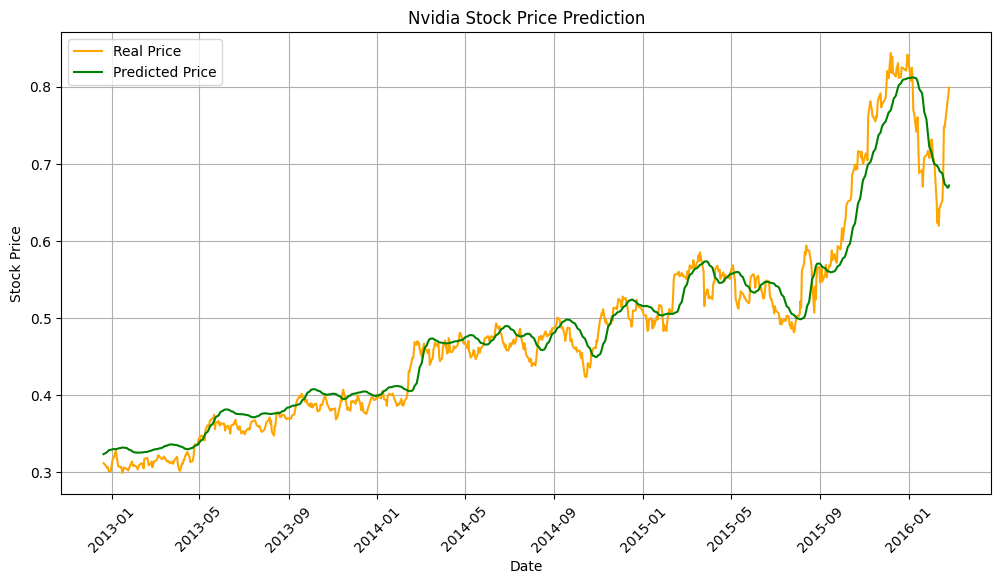

In [ ]:
plt.figure(figsize=(12,6)) #stworzenie figury wykresu o nadanym rozmiarze

test_dates = dates[3501:4300] #zakres wykresu

plt.plot(test_dates, real_price, color='orange', label='Real Price') #wykres cen rzeczywistych
plt.plot(test_dates, predicted_price, color='green', label='Predicted Price') #wykres cen przeywidywanych

plt.title('Nvidia Stock Price Prediction') #tytuł
plt.xlabel('Date') #data
plt.ylabel('Stock Price') #cena
plt.xticks(rotation=45) #obrót daty
plt.legend() #wypisanie legendy
plt.grid(True) #dodanie siatki
plt.show() #wyświetlenie wykresu

In [ ]:
#metrics
import math #biblioteka dostarczająca funkcje matematyczne

rmse = math.sqrt(metrics.mean_squared_error(predicted_price, real_price)) #obliczenie średniego błędu miedzy przewidywanymi a rzeczywistymi cenami
print(f'RMSE {rmse}') #wyświetlenie wyniku - im mniejsza liczba tym lepsza jakość modelu
print(f'MAE {metrics.mean_absolute_error(predicted_price, real_price)}') #błąd absolutny (różnica) im mniejsza liczba tym lepsza jakość modelu

RMSE 0.027212311099980496
MAE 0.02024155653761386
